# DistilBERT
https://huggingface.co/distilbert/distilbert-base-uncased

In [98]:
!nvidia-smi

Thu Feb 27 14:58:50 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.03             Driver Version: 535.216.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          On  | 00000000:C1:00.0 Off |                   On |
| N/A   32C    P0              59W / 300W |   8466MiB / 81920MiB |     N/A      Default |
|                                         |                      |              Enabled |
+-----------------------------------------+----------------------+--

+------------------+--------------------------------+-----------+-----------------------+
                                                                                         
+---------------------------------------------------------------------------------------+
| Processes:                                                                            |
|  GPU   GI   CI        PID   Type   Process name                            GPU Memory |
|        ID   ID                                                             Usage      |
|=======================================================================================|
|    0    8    0    1392647      C   ...itbucket/epb21/nlp/.venv/bin/python     3462MiB |
+---------------------------------------------------------------------------------------+


In [ ]:
%pip install transformers 
%pip install datasets 
%pip install torch 
%pip install scikit-learn
%pip install pandas
%pip install seaborn
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import logging

# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [ ]:
import torch
import pandas as pd
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import ast
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from typing import Dict, Any, List


### Load DistilBert

In [ ]:
# Load tokenizer and model
MODEL_NAME = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2) 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


### Load test data and split into training/test data

In [ ]:
class DontPatronizeMeDataset(Dataset):
  def __init__(
    self, 
    data: pd.DataFrame, 
    tokenizer: DistilBertTokenizer, 
    max_length: int = 128
  ):
    self.data = data.reset_index(drop = True)
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__(self) -> int:
    return len(self.data)

  def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
    text = str(self.data.loc[idx, "text"])
    label = self.data.loc[idx, "binary_label"]

    encoding = self.tokenizer(
      text, 
      add_special_tokens=True,
      max_length=self.max_length,
      padding="max_length",
      truncation=True,
      return_tensors="pt"
    )

    encoding = { key: value.squeeze(0) for key, value in encoding.items() }
    encoding["labels"] = torch.tensor(label, dtype=torch.long)

    return encoding


In [ ]:
def convert_to_binary(label_array: Any) -> int:
    """
    Given a 7-label array (or its string representation), return 1 if any element is 1, else 0.
    """
    # If label_array is a string, convert it to a list
    if isinstance(label_array, str):
        try:
            label_list = ast.literal_eval(label_array)
        except Exception as e:
            raise ValueError(f"Error parsing label array: {label_array}") from e
    else:
        label_list = label_array
    return int(any(label_list))

In [ ]:
TEXT_DATA_PATH = "data/dontpatronizeme_pcl.tsv"

column_names = ["par_id", "art_id", "keyword", "country", "text", "orig_label"]
text_data = pd.read_csv(TEXT_DATA_PATH, sep="\t", header=None, names=column_names)

print("Text Data shape:", text_data.shape)

TRAIN_ALLOC_PATH = "data/train_semeval_parids-labels.csv"
DEV_ALLOC_PATH = "data/dev_semeval_parids-labels.csv"

train_alloc = pd.read_csv(TRAIN_ALLOC_PATH)
dev_alloc = pd.read_csv(DEV_ALLOC_PATH)

print("Train allocation shape:", train_alloc.shape)
print("Dev allocation shape:", dev_alloc.shape)

train_data = pd.merge(train_alloc, text_data, on="par_id")
train_data["binary_label"] = train_data["label"].apply(convert_to_binary)

dev_data = pd.merge(dev_alloc, text_data, on="par_id")
dev_data["binary_label"] = dev_data["label"].apply(convert_to_binary)

print("Merged train data shape:", train_data.shape)
print("Merged dev data shape:", dev_data.shape)

train_split, test_split = train_test_split(
  train_data,
  test_size = 0.2,
  random_state = 16,
  stratify=train_data["binary_label"]
)

internal_train_dataset = DontPatronizeMeDataset(train_split, tokenizer, max_length=128)
internal_test_dataset = DontPatronizeMeDataset(test_split, tokenizer, max_length=128)

internal_train_loader = DataLoader(internal_train_dataset, batch_size=16, shuffle=True)
internal_test_loader = DataLoader(internal_test_dataset, batch_size=16, shuffle=False)

dev_dataset = DontPatronizeMeDataset(dev_data, tokenizer, max_length=128)
test_loader = DataLoader(dev_dataset, batch_size=16, shuffle=False)

Text Data shape: (10469, 6)
Train allocation shape: (8375, 2)
Dev allocation shape: (2094, 2)
Merged train data shape: (8375, 8)
Merged dev data shape: (2094, 8)


In [ ]:
train_data

,par_id,label,art_id,keyword,country,text,orig_label,binary_label
0,4341,"[1, 0, 0, 1, 0, 0, 0]",@@17139403,poor-families,gb,"The scheme saw an estimated 150,000 children f...",4,1
1,4136,"[0, 1, 0, 0, 0, 0, 0]",@@22273328,homeless,za,Durban 's homeless communities reconciliation ...,2,1
2,10352,"[1, 0, 0, 0, 0, 1, 0]",@@21102155,poor-families,lk,The next immediate problem that cropped up was...,4,1
3,8279,"[0, 0, 0, 1, 0, 0, 0]",@@21220476,vulnerable,nz,Far more important than the implications for t...,2,1
4,1164,"[1, 0, 0, 1, 1, 1, 0]",@@14727121,poor-families,gh,To strengthen child-sensitive social protectio...,4,1
...,...,...,...,...,...,...,...,...
8370,8380,"[0, 0, 0, 0, 0, 0, 0]",@@3172947,refugee,gb,Rescue teams search for survivors on the rubbl...,0,0
8371,8381,"[0, 0, 0, 0, 0, 0, 0]",@@23593795,hopeless,ke,The launch of ' Happy Birthday ' took place la...,0,0
8372,8382,"[0, 0, 0, 0, 0, 0, 0]",@@9222273,homeless,pk,"The unrest has left at least 20,000 people dea...",0,0
8373,8383,"[0, 0, 0, 0, 0, 0, 0]",@@25979256,hopeless,pk,You have to see it from my perspective . I may...,0,0


### Baseline Evaluation

In [ ]:
def evaluate(loader: DataLoader):
  y_true = []
  y_pred = []

  model.eval()
  with torch.no_grad():
      for batch in loader:
          inputs = batch["input_ids"].to(device)
          attention_mask = batch["attention_mask"].to(device)
          labels = batch["labels"].to(device)

          outputs = model(inputs, attention_mask=attention_mask)
          logits = outputs.logits

          predictions = torch.argmax(logits, dim=1)

          y_true.extend(labels.cpu().numpy().tolist())
          y_pred.extend(predictions.cpu().numpy().tolist())

  # Convert to numpy arrays
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  # Compute metrics
  accuracy = accuracy_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred, average="macro")

  return accuracy, f1

In [ ]:
# approx 1min
internal_test_acc, internal_test_f1 = evaluate(internal_test_loader)

# Acc: 0.905075
# F1:  0.475086
print(f"Internal Test Accuracy: {internal_test_acc:.6f}")
print(f"Internal Test F1 Score: {internal_test_f1:.6f}")

# approx 1min
test_acc, test_f1 = evaluate(test_loader)

# Acc: 0.904967
# F1:  0.475056
print(f"Test Accuracy: {test_acc:.6f}")
print(f"Test F1 Score: {test_f1:.6f}")

Internal Test Accuracy: 0.814328
Internal Test F1 Score: 0.500092
Test Accuracy: 0.829990
Test F1 Score: 0.520821


### Fine-tune the model 

In [20]:
num_epochs = 3
lr = 2e-5

optimiser = optim.AdamW(model.parameters(), lr=lr)
total_steps = len(internal_train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
  optimiser, 
  num_warmup_steps=0, 
  num_training_steps=total_steps
)

model.train()
for epoch in range(num_epochs):
  total_loss: float = 0.0

  for batch in internal_train_loader:
    optimiser.zero_grad()

    inputs = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)

    outputs = model(inputs, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss

    loss.backward()
    optimiser.step()
    scheduler.step()

    total_loss += loss.item()

  avg_loss = total_loss / len(train_loader)
  print(f"Epoch {epoch + 1}/{num_epochs} | Loss: {avg_loss:.6f}")

NameError: name 'train_loader' is not defined

### Evaluate the model

In [ ]:
# approx 1min
internal_test_acc, internal_test_f1 = evaluate(internal_test_loader)

# Acc: 0.905075
# F1:  0.475086
print(f"Internal Test Accuracy: {internal_test_acc:.6f}")
print(f"Internal Test F1 Score: {internal_test_f1:.6f}")

# approx 1min
test_acc, test_f1 = evaluate(test_loader)

# Acc: 0.904967
# F1:  0.475056
print(f"Test Accuracy: {test_acc:.6f}")
print(f"Test F1 Score: {test_f1:.6f}")

Internal Test Accuracy: 0.923582
Internal Test F1 Score: 0.753774
Test Accuracy: 0.925501
Test F1 Score: 0.758075


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

### Examine Confusion Matrix

[[1516    0]
 [ 159    0]]


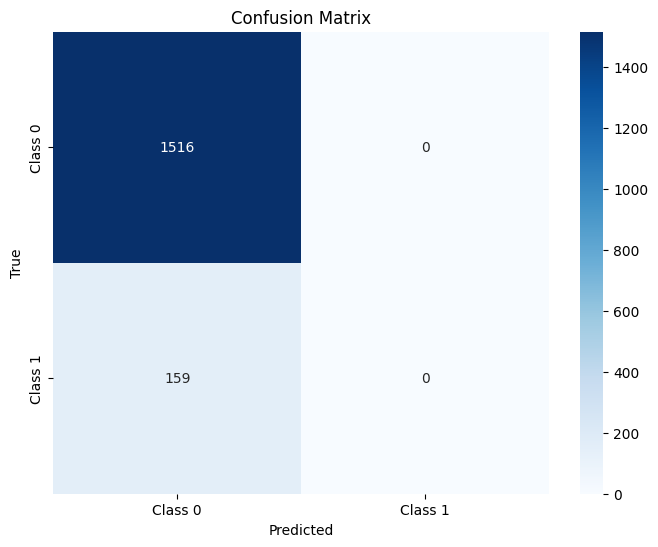

In [ ]:
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[f"Class {i}" for i in range(2)], 
            yticklabels=[f"Class {i}" for i in range(2)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()